# NLP analysis and classification of subReddits


## Part II - Cleaning, preprocessing & EDA
---

We'll import all our required libraries up here.

In [1]:
#import all potential libraries

import pandas as pd, \
       numpy as np, \
       requests, time, nltk, \
       datetime as dt, \
       matplotlib.pyplot as plt, seaborn as sns, \
       re #regex

#NLP transformers
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer

import gensim.downloader as api #allows us to get word2vec anf glove embeddings that we need
from gensim.models.word2vec import Word2Vec
from transformers import pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, \
                                            TfidfVectorizer


#classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import (RandomForestClassifier, \
                              ExtraTreesClassifier, \
                              BaggingClassifier,
                              GradientBoostingClassifier, \
                              AdaBoostClassifier, \
                              VotingClassifier)

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from xgboost import XGBRegressor, XGBClassifier
from sklearn.naive_bayes import MultinomialNB


#metrics / model preprocessing
from sklearn.metrics import (accuracy_score, confusion_matrix, \
                             plot_confusion_matrix, \
                             recall_score, precision_score)

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, \
                                    GridSearchCV, \
                                    cross_val_score, \
                                    RandomizedSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from scipy.stats import uniform, loguniform

# easier to see full text with a bigger maxwidth:
pd.options.display.max_colwidth = 200

#show grid on plots
sns.set_style('darkgrid')

In [2]:
#pip install python-Levenshtein
#this is for the gensim.similarities.levenshtein submodule

- - - 

### Pull in the files, resulting from our scrapes, into dataframes!

In [3]:
movie_deets2 = pd.read_csv('../data_outputs/good_movie_deets2.csv')
bad_deets2 = pd.read_csv('../data_outputs/bad_movie_deets2.csv')
all_movies = pd.read_csv('../data_outputs/all_movies.csv')

### Get basic stats

Let's look at basic stats about our data.

How many records do we have, prior to cleaning?

In [4]:
movie_deets2.shape

(8805, 9)

In [5]:
bad_deets2.shape

(8180, 9)

In [6]:
all_movies.shape

(9404, 9)

What did we pull in?

In [7]:
movie_deets2.head(2)

,title,selftext,subreddit,created_utc,author,is_self,score,num_comments,timestamp
0,"Listen,share,repost ""culgrin d mayor"" Africa gorilla volume 1 EP on all PLATFORMS",NaN,MovieDetails,1619213155,culgrin1,False,1,0,2021-04-23
1,"In Repo Man (1984), Miller says to Otto “suppose you're thinkin' about a plate o' shrimp. Suddenly someone'll say, plate, or shrimp, or plate o' shrimp out the blue” as an example of his concept o...",NaN,MovieDetails,1619214866,VictorBlimpmuscle,False,1,12,2021-04-23


In [8]:
bad_deets2.head(2)

,title,selftext,subreddit,created_utc,author,is_self,score,num_comments,timestamp
0,"In the movie Bullworth (1998), a police officer is seen not shooting black people.",NaN,shittymoviedetails,1619214935,Wuz314159,False,1,1,2021-04-23
1,"The Nightmare Before Christmas (1993), when he arrives at Christmas Town, Jack sings ""what's this? There's white things in the air"". 22 seconds later he sings ""there are children throwing snowball...",NaN,shittymoviedetails,1619217853,Nerf_Herder86,False,1,0,2021-04-23


In [9]:
all_movies.head(2)

,title,selftext,subreddit,created_utc,author,is_self,score,num_comments,timestamp
0,Russian sci-fi film about artificial intelligence testing.,NaN,movies,1619216594,Anixx,False,1,0,2021-04-23
1,"Just why! Miranda is not in the Lizzie McGuire Movie and while the movie was still good, there's a huge hole without Miranda especially when they go to a country like Rome. And Miranda was already...",[removed],movies,1619217134,EvilIceCream1755,True,1,0,2021-04-23


Let's actually merge our dataframes to make it easier for processing.

In [10]:
#pd.concat([df1, df2])
df = pd.concat([bad_deets2, movie_deets2, all_movies])
df.head(1)

,title,selftext,subreddit,created_utc,author,is_self,score,num_comments,timestamp
0,"In the movie Bullworth (1998), a police officer is seen not shooting black people.",NaN,shittymoviedetails,1619214935,Wuz314159,False,1,1,2021-04-23


In [11]:
df.shape

(26389, 9)

What data types are we dealing with?

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26389 entries, 0 to 9403
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         26389 non-null  object
 1   selftext      7350 non-null   object
 2   subreddit     26389 non-null  object
 3   created_utc   26389 non-null  int64 
 4   author        26389 non-null  object
 5   is_self       26389 non-null  bool  
 6   score         26389 non-null  int64 
 7   num_comments  26389 non-null  int64 
 8   timestamp     26389 non-null  object
dtypes: bool(1), int64(3), object(5)
memory usage: 1.8+ MB


A few objects, like text fields, are expected, and will need to be transformed / vectorized for modeling.

Let's also convert the time stamps to a usable format, just in case they come in handy for modeling.

A few objects, like text fields, are expected, and will need to be transformed / vectorized for modeling.

Let's also convert the time stamps to a usable format, just in case they come in handy for modeling. Further, the UTC is actually not really something we want in our model, and it's not really numeric either (it's a datetime concept if anything). Let's take care of that as well.

In [13]:
#convert time stamps
#.apply(pd.to_datetime) - ref.: https://stackoverflow.com/questions/26763344/convert-pandas-column-to-datetime
df['timestamp'] = df['timestamp'].apply(pd.to_datetime)
df['created_utc'] = df['created_utc'].apply(pd.to_datetime)

Now we can try to obtain basic descriptive stats.

In [14]:
df.describe().round(1)

,score,num_comments
count,26389.0,26389.0
mean,57.4,18.7
std,1400.0,124.0
min,0.0,0.0
25%,1.0,0.0
50%,1.0,2.0
75%,1.0,5.0
max,72489.0,6036.0


Not much to look at here at the moment. The notables are the distribution of comments. We'll want to perform some more specific distribution analyses a little down the road, once done with the cleaning, to make more sense out of these stats.

Where might we have issues with missing data?

In [15]:
df.isnull().sum()

title               0
selftext        19039
subreddit           0
created_utc         0
author              0
is_self             0
score               0
num_comments        0
timestamp           0
dtype: int64

- - - 

### Imputation and cleaning strategy

Our strategy is to first remove anything with selftext appearing to have been deleted. Even though these are not read as nulls, they effectively are, for our purposes.

We knew that we'd have quite a few issues with missing self-text, when we shose to scrape unfiltered data. To remedy this, we could impute all nulls where self text is missing with the post's title, but this might result in inadvertent text duplicates when we train our model. So, instead, we are going to engineer a new column and merge the self-text and title text. _Note: Attribution for the idea to Riley R._

We will further dedupe and get rid of ostensibly spammy looking posts, by adding stop words like "repost", "reshare", as well as dropping any dominant authors or ones that sound spammy ("bot", "auto").

We will also need to get rid of any link references.

Okay, let's start by dropping anything with the word "removed" or "deleted". It's a tiny portion of our set, so I am not super worried about losing those rows of data.

In [16]:
#df[~df['col'].str.contains('value1|value2')]
#syntactic ref from https://stackoverflow.com/questions/52297740/typeerror-bad-operand-type-for-unary-float

df = df[~df['selftext'].str.contains('deleted|removed', na=False)]

#df = df[df.selftext != 'deleted']
#df = df[df.selftext != 'removed']

In [17]:
#check
df.head(1)

,title,selftext,subreddit,created_utc,author,is_self,score,num_comments,timestamp
0,"In the movie Bullworth (1998), a police officer is seen not shooting black people.",NaN,shittymoviedetails,1970-01-01 00:00:01.619214935,Wuz314159,False,1,1,2021-04-23


Let's confirm that those bad rows are gone.

In [18]:
#check again that removed and deleted selftexts are no longer in frame
df['selftext'].value_counts().sort_values(ascending=False)[:2]

I believe people forget to mention why Lucy keeps egging on about the thoughts of ending this nonexistent relationship. If this is meant to be an idealized girlfriend, then there’d be no need for her to feel uneasy about moving on from Jake. That could mean two things: Jake originally planned to stop living in his own thoughts of the past and just face reality. Or: This movie is about Jake tragically facing the truth but having an inability to live on. \n\nThe scene with Jake’s parents could represent his final goodbye’s with them. This entire interaction holds so many contradictions, but what I want to focus on is the mom mistaking Jake’s 20th birthday to be his 50th. Jake could’ve actually been there in the flesh or Jake couldn’t muster the perfect time to mentally leave his parents. The inconsistencies in Lucy’s telling of how they first met could support this too. After the runaround of a story, she mentions how Jake finally became a “normal” and “funny” person.. but that doesn’t s

We should see the dropped rows reflected in the shape.

In [19]:
#Confirm data frame has shrunk by 227 rows
df.shape

(21798, 9)

Finally, the nulls should still be intact -- we are going to take care of that in a moment.

In [20]:
df.isnull().sum()

title               0
selftext        19039
subreddit           0
created_utc         0
author              0
is_self             0
score               0
num_comments        0
timestamp           0
dtype: int64

We also need to get rid of the link mentions.

In [21]:
#df['column'] = df['column'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#from https://stackoverflow.com/questions/51994254/removing-url-from-a-column-in-pandas-dataframe/51994366

df['selftext'] = df['selftext'].replace(r'http\S+', '', regex=True).replace(
    r'www\S+', '', regex=True).replace(r'\&amp\S+', '', regex=True)

In [22]:
type(df['selftext'])

pandas.core.series.Series

In [23]:
#from https://stackoverflow.com/questions/44227748/removing-newlines-from-messy-strings-in-pandas-dataframe-cells

df.replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=["",""], regex=True, inplace=True)

df = df.replace(r'\\n','', regex=True) 

In [24]:
#Thanks to Aderinsola, Dan and Riley R. for collaboration on this code
df = df.replace(r'[^a-zA-Z0-9]', ' ', regex=True)

Now let's create our all-text column that we'll train on later.

However, we still need an imputation strategy for the NaNs. I'm choosing to fill them in with spaces.

In [25]:
#nuke nulls
df['selftext'].fillna('', inplace=True)

In [26]:
#get new all-text column.
df['all_text'] = df['title'] + '. ' + df['selftext']

#check result
df.head(25).sort_values(by = 'selftext', ascending = False)

,title,selftext,subreddit,created_utc,author,is_self,score,num_comments,timestamp,all_text
0,In the movie Bullworth 1998 a police officer is seen not shooting black people,,shittymoviedetails,1970-01-01 00:00:01.619214935,Wuz314159,False,1,1,2021-04-23,In the movie Bullworth 1998 a police officer is seen not shooting black people .
13,After the commercial success of Kitchen Gun and Toilet Grenade Peter Serafinowicz expanded his business to offer a larger variety of cleaning products in John Wick Chapter 2,,shittymoviedetails,1970-01-01 00:00:01.619251458,Raoshard,False,1,46,2021-04-24,After the commercial success of Kitchen Gun and Toilet Grenade Peter Serafinowicz expanded his business to offer a larger variety of cleaning products in John Wick Chapter 2.
23,Guy makes his interestingly bizarre rendition that s addictive,,shittymoviedetails,1970-01-01 00:00:01.619283112,TitsAmazing,False,1,0,2021-04-24,Guy makes his interestingly bizarre rendition that s addictive.
22,The film title No Country For Old Men 2007 refers to the fact that Florida is not in fact a country It is a state,,shittymoviedetails,1970-01-01 00:00:01.619282093,NuclearJesusMan,False,1,5,2021-04-24,The film title No Country For Old Men 2007 refers to the fact that Florida is not in fact a country It is a state .
21,In 2001 A Space Odyssey 1968 much of the film focuses on characters walking slowly in silence This is a reference to the fact that holy fuck this movie is boring as all hell,,shittymoviedetails,1970-01-01 00:00:01.619281182,NuclearJesusMan,False,1,20,2021-04-24,In 2001 A Space Odyssey 1968 much of the film focuses on characters walking slowly in silence This is a reference to the fact that holy fuck this movie is boring as all hell .
20,In Captain America The Winter Soldier 2014 the Winter Soldier looks like a crab in this scene This is a reference to the actors name Sebastian who is a crab in another Disney film The Litt...,,shittymoviedetails,1970-01-01 00:00:01.619280462,KennKennyKenKen,False,1,61,2021-04-24,In Captain America The Winter Soldier 2014 the Winter Soldier looks like a crab in this scene This is a reference to the actors name Sebastian who is a crab in another Disney film The Litt...
19,In Justice League 2021 the kid from the liquor store whom Bruce was referring to is actually McLovin,,shittymoviedetails,1970-01-01 00:00:01.619278471,pale guy,False,1,0,2021-04-24,In Justice League 2021 the kid from the liquor store whom Bruce was referring to is actually McLovin .
18,Captain America 4 TBA has recently been announced Here is the leaked trailer,,shittymoviedetails,1970-01-01 00:00:01.619277392,KennKennyKenKen,False,1,13,2021-04-24,Captain America 4 TBA has recently been announced Here is the leaked trailer .
17,In The Curious Case of Benjamin Button 2008 Brad Pitt became old because fight clubs can really take a toll on a guy,,shittymoviedetails,1970-01-01 00:00:01.619275733,pale guy,False,1,0,2021-04-24,In The Curious Case of Benjamin Button 2008 Brad Pitt became old because fight clubs can really take a toll on a guy .
16,in mortal kombat Hanzo says Cole Young don t let the bloodline die in Japanese Cole Young,,shittymoviedetails,1970-01-01 00:00:01.619270578,invertedparadX,False,1,0,2021-04-24,in mortal kombat Hanzo says Cole Young don t let the bloodline die in Japanese Cole Young .


In [27]:
df['selftext'].sort_values(ascending=False)

7446    tl dr  The new Mulan sucksI m Chinese  so I was excited as hell that we were getting a new  grittier Mulan that seemed to pay more homage to the original legend  and was more respectful to Chinese...
6176                                                                                                                                                             tl dr   outraged  Michael Keaton must respond 
324     this was a movie that took place in a steampunk asian setting  the characters were glove puppets like thunderbolt fantasy or pili  and there was a robot  the movie tittle is also the name of the r...
1644    this is the scene    i saw this movie back in 2012 in 3D and it was so good  probably the best movie i ve seen in 3D  in rewatching it  i m still so impressed by the feel of the flying fish scene ...
2050    this is a random post but I just rewatched this again on crackle and I love this movie man  I m not huge into scifi like some but I like it enough if it s compe

In [28]:
#get rid of spammy text / authors by creating stop words list -- or do this underneath, in the NLP part.

--- 

### Analysis

Now that we are more or less done cleaning, let's understand the density and usefulness of our content, by analyzing the volume of comments and looking for the richness of the text columns.

We will be able to perform additional text analysis later on, once we have transformed (vectorized) our text.

First, let's take a look at the distribution of posts by the volume of comments.

In [29]:
df['num_comments'].value_counts()[:50]

0     7083
2     2767
1     2159
3     1578
4     1282
5      786
6      641
7      452
8      406
9      334
10     301
11     251
12     245
13     185
14     173
16     148
15     138
17     123
20     115
18     102
19      88
21      85
22      71
23      66
25      66
26      65
27      62
24      56
29      46
30      46
28      46
36      43
33      39
35      37
34      37
31      36
42      35
37      33
32      32
41      30
43      28
54      28
47      26
39      25
44      24
40      23
38      20
46      19
45      18
52      18
Name: num_comments, dtype: int64

In [30]:
df['num_comments'].mean()

22.316726305165613

In [31]:
df['num_comments'].mode()

0    0
dtype: int64

In [32]:
df['num_comments'].median()

2.0

In [33]:
df['num_comments'].max()

6036

Judging from this, the vast majority of posts have no comments at all. The average number of comments is 22. There are also extreme outliers exceeding 1000 comments.

Let's visualize this.

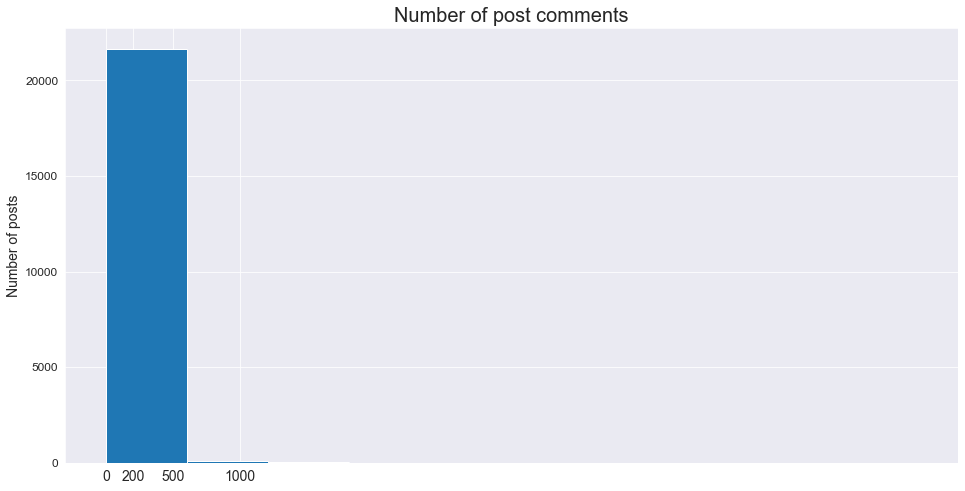

In [34]:
#code ref from Gwen's lab review lesson 4/27/2021

plt.figure(figsize = (16,8));
df['num_comments'].plot(kind='hist');
plt.title('Number of post comments', size =20);
plt.xticks([0, 200, 500, 1000], size=14);
plt.yticks(size=12);
plt.ylabel('Number of posts', size=14);

Anything beyond 500 comments (an already huge number barely registers); there is definitely a huge outlier with something getting 6K comments; we might want to remove this outlier, to reduce noise in our data.

Now let's look at distribution by authors. Let's see if any stick out as dominant, which can either mean that they are highly engaged on Reddit, or it could be a signal of spam.

Further, we might want to cross-validate if any others appear across _multiple_ of our subReddits!

In [35]:
df['author'].value_counts()[:50] #get only unique

wednesdaygiftinfo       434
Numerous Lemon          282
Ornery Control 9474     264
Tokyono                 191
 deleted                189
pale guy                154
random guy somewhere    138
klsi832                 108
Comic Book Reader        92
sirsquid                 82
chanma50                 73
MovieBattleGame          68
alizamessy               63
Sisiwakanamaru           62
VictorBlimpmuscle        53
ggroover97               51
KscILLBILL               46
ToyVaren                 46
invertedparadX           43
SpaceMyopia              41
gautsvo                  41
james 1990               40
movihq                   33
prsnreddit               31
RayInRed                 31
lopezjessy               30
LiteraryBoner            27
CephalopodRed            27
Jack Earth 2             26
randomspawner            26
Iamnotbroke              25
MistleFeast              25
Mostafa Dahroug          25
skyfall91404             25
Russian Bagel            24
Puzzleheaded Fun 257

In [36]:
df['author'].value_counts().mean()

1.7245253164556962

We do have some authors that have posted hundreds of posts here, with an average author posting approximately twice. But nothing really obviously sticks out as concerning, at the moment, based on the author's handle alone -- that is, if we were looking for glaringly "spammy" signals with a naked eye (i.e. sans any spam detection machine like spam vs. ham). We'll check for the word 'repost' and 'reshare' as well; although we should have hopefully gotten rid of most of that content noise by stripping out the URLs from the text fields earlier.

But how many unique authors are there?

In [37]:
#unique authors
#from Gwen's NLP lab review
len(df['author'].unique())

12640

This checks out, given that we saw roughly 2 posts / author, above.

What if authors post to more than one of the subreddits?

In [38]:
# I want to be able to do groupby's the old fashioned way! Thanks for the find to Riley Robertson!
#! pip install -U pandasql

In [39]:
#docstring: https://pypi.org/project/pandasql/
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

def pysqldf(q):
    #add this to your script if you get tired of calling locals()
    return sqldf(q, globals())

In [40]:
#groupby the authors by subreddit -- check query construct is returning, what we want!
#fix this w/ Gwen's query (posted during 4/19 BH), if time, or kill
df = df


q = """
    SELECT DISTINCT
           count(selftext) as posts,
           subreddit,
           author
           
           FROM
              df
           GROUP BY
              author
           ORDER BY
              subreddit;
              
"""
print(pysqldf(q).head())

   posts     subreddit                author
0      1  MovieDetails           Godzilla   
1      1  MovieDetails                 BMO  
2      1  MovieDetails    Hello my name is  
3      1  MovieDetails            Leonardo  
4      1  MovieDetails        Reginaphalange


Let's go ahead and see when most of our posts are from.

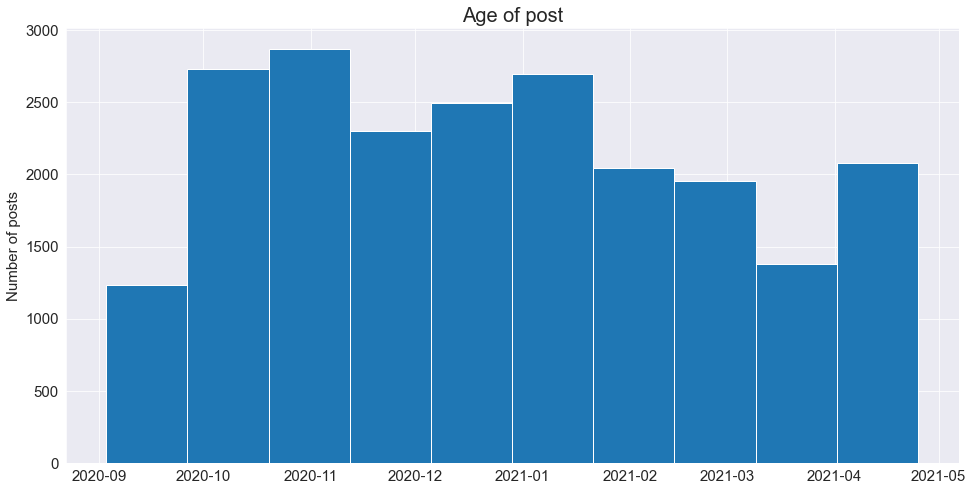

In [41]:
#get post age
plt.figure(figsize = (16, 8))
plt.title('Age of post', size = 20);
df['timestamp'].hist();
plt.xticks(size=15)
plt.yticks(size=15)
plt.ylabel('Number of posts', size = 15);

Our posts come from September 2020 to present. ( _Note: this may be a function of how far back we scraped and not in itself meaningful. This was an attempt to find possible seasonality, but there isn't really a pattern I can establish here, and it would be more meaningful to look at a year+ worth's._ )

Finally, let's look at the distribution of original posts, compared to reposts.

In [42]:
df['is_self'].value_counts(normalize=True).round(2)

False    0.86
True     0.14
Name: is_self, dtype: float64

In [43]:
#strip out repost / reshare stuff

As we can see, most posts are actually reposts in our threads, and we anticipate that the overall quality of our posts might thus be on the lower side.

So how well do most posts score?

(More on this here: [What do Reddit post scores mean?](https://www.reddit.com/wiki/faq#wiki_how_is_a_submission.27s_score_determined.3F).)

In [44]:
df['score'].mean()

69.0378933847142

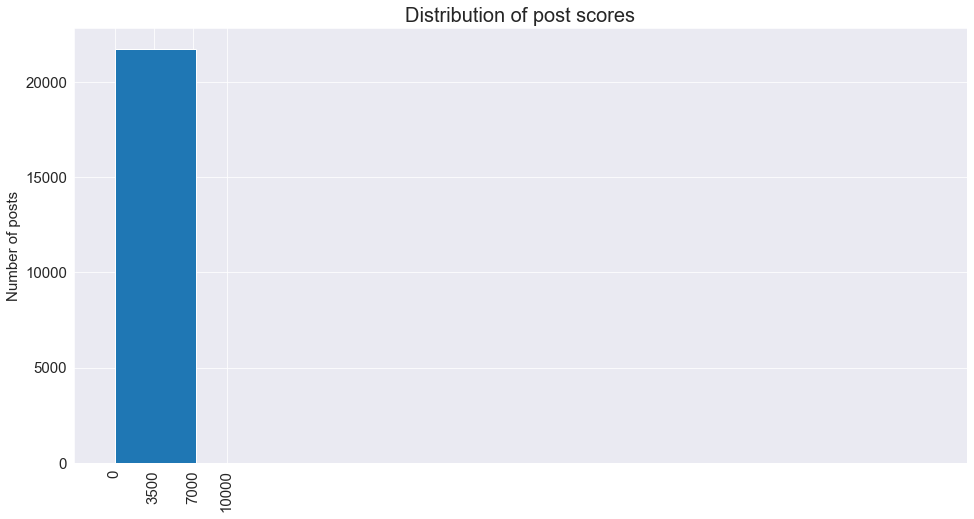

In [45]:
#dist of scores
plt.figure(figsize = (16,8))
df['score'].plot(kind = 'hist');
plt.title('Distribution of post scores', size= 20)
plt.yticks(size=15)
plt.xticks([0, 3500, 7000, 10_000], size=15,rotation = 90)
plt.ylabel('Number of posts', size = 15);

Looks like this is about all we can do, before further transformation.

- - -

## Part III: NLP & feature eng

In [46]:
df.columns

Index(['title', 'selftext', 'subreddit', 'created_utc', 'author', 'is_self',
       'score', 'num_comments', 'timestamp', 'all_text'],
      dtype='object')

### Sentiment analysis (feature eng.)

OK, so we want to geta bit of an idea about the kinds of things people post about.

But what is the temperature of the room? And can we tell, from the heat -- or mediocreness -- of the conversation, where our posts might belong?

Let's take a look, using sentiment analysis. We are going to use VADER, which, according to General Assembly lesson material, works particularly well on social media context; and, well, Reddit is _kind of_ like social media in many regards, not the least of which is commenting, threading, participating in a community, and overall, being a bit of a public market of the stream of all of our (topical) consciousness.

### Modeling workflow

Model workflow review ( _thanks, Heather R.!_ ):

1. We will perform sentiment analysis on the whole dataset and get polarity scores
2. Vectorize (**small data leakage)
3. We will train test split, using the sentiment scores (either filtered or compound), to set up the X matrix
4. We will then fit-transform to X-train and transform on X-test and vectorize. Note 1: setting max features, stopwords can help control the size of the data here. Note 2: only pull out the X train, excluding sentiment scores (because only text data needs to be vectorized).
5. Concatenate the vectorized output back w/ the original X features and sentiment scores.

In [47]:
#First, convert to a list of strings; full reference in this entire section to the sentiment analysis lesson from Heather Robbins
corpus = list(df['all_text'])
while("" in corpus) : corpus.remove("") #from: https://www.geeksforgeeks.org/python-remove-empty-strings-from-list-of-strings/
print(len(corpus))
corpus[:100]

21798


['In the movie Bullworth  1998   a police officer is seen not shooting black people . ',
 'The Nightmare Before Christmas  1993   when he arrives at Christmas Town  Jack sings  what s this  There s white things in the air   22 seconds later he sings  there are children throwing snowballs instead of throwing heads   This is because Danny Elfman was deaf and can t hear what he just sang. ',
 'In Bumblebee  2018   we see a roll of toilet paper  which is used to get rid of shit  in the revenge scene  This is a reference to how this reboot is getting rid of the shit that Michael Bay made in the first 5 Transformers movies . ',
 'In Frozen  2013  Anna asks  Why have a ballroom with no balls   This is a direct reference to there being no males in the kingdom . ',
 'johnny cage could not appear in mortal kombat due to scheduling conflicts shooting the real world  back at it like a crack addict. ',
 'In Mortal Kombat  2021  in this scene you can clearly see a crew member in the shot  Very irres

Looks like we generated a corpus of just over 2500 documents.

We'll instantiate our VADER analyzer and check it out by producing some polarity scores on a post.

In [48]:
#sentiment analysis
#instantiate VADER
vader = SentimentIntensityAnalyzer()

#Get polarity scores for a random post for a quick check
print(vader.polarity_scores(corpus[20]))

print(corpus[20])

{'neg': 0.0, 'neu': 0.932, 'pos': 0.068, 'compound': 0.3612}
In Captain America   The Winter Soldier  2014   the Winter Soldier looks like a crab in this scene  This is a reference to the actors name Sebastian  who is a crab in another Disney film  The Little Mermaid  1989  . 


In [49]:
type(corpus)

list

Now let's do this for all of our data.

In [50]:
sentiment = []    

for post in corpus:
    scores = vader.polarity_scores(post)
    scores['all_text'] = post
    sentiment.append(scores)

sentiment_df = pd.DataFrame(sentiment)
sentiment_df.head()

,neg,neu,pos,compound,all_text
0,0.000,1.000,0.0,0.0000,In the movie Bullworth 1998 a police officer is seen not shooting black people .
1,0.000,1.000,0.0,0.0000,The Nightmare Before Christmas 1993 when he arrives at Christmas Town Jack sings what s this There s white things in the air 22 seconds later he sings there are children throwing snowball...
2,0.209,0.791,0.0,-0.8910,In Bumblebee 2018 we see a roll of toilet paper which is used to get rid of shit in the revenge scene This is a reference to how this reboot is getting rid of the shit that Michael Bay made ...
3,0.173,0.827,0.0,-0.5267,In Frozen 2013 Anna asks Why have a ballroom with no balls This is a direct reference to there being no males in the kingdom .
4,0.104,0.797,0.1,-0.0258,johnny cage could not appear in mortal kombat due to scheduling conflicts shooting the real world back at it like a crack addict.


In [51]:
sentiment_df.shape

(21798, 5)

In [52]:
df.shape

(21798, 10)

In [53]:
sentiment_df.head(1)

,neg,neu,pos,compound,all_text
0,0.0,1.0,0.0,0.0,In the movie Bullworth 1998 a police officer is seen not shooting black people .


In [54]:
sentiment_df.index

RangeIndex(start=0, stop=21798, step=1)

In [55]:
df.head(1)

,title,selftext,subreddit,created_utc,author,is_self,score,num_comments,timestamp,all_text
0,In the movie Bullworth 1998 a police officer is seen not shooting black people,,shittymoviedetails,1970-01-01 00:00:01.619214935,Wuz314159,False,1,1,2021-04-23,In the movie Bullworth 1998 a police officer is seen not shooting black people .


In [56]:
#reset index due to earlier dropped rows
df.reset_index(inplace=True)
sentiment_df.reset_index(inplace=True)

In [57]:
#set target to equal to our subreddit - bin. / conversion to num not req.
sentiment_df['target'] =df['subreddit']
sentiment_df.head()

,index,neg,neu,pos,compound,all_text,target
0,0,0.000,1.000,0.0,0.0000,In the movie Bullworth 1998 a police officer is seen not shooting black people .,shittymoviedetails
1,1,0.000,1.000,0.0,0.0000,The Nightmare Before Christmas 1993 when he arrives at Christmas Town Jack sings what s this There s white things in the air 22 seconds later he sings there are children throwing snowball...,shittymoviedetails
2,2,0.209,0.791,0.0,-0.8910,In Bumblebee 2018 we see a roll of toilet paper which is used to get rid of shit in the revenge scene This is a reference to how this reboot is getting rid of the shit that Michael Bay made ...,shittymoviedetails
3,3,0.173,0.827,0.0,-0.5267,In Frozen 2013 Anna asks Why have a ballroom with no balls This is a direct reference to there being no males in the kingdom .,shittymoviedetails
4,4,0.104,0.797,0.1,-0.0258,johnny cage could not appear in mortal kombat due to scheduling conflicts shooting the real world back at it like a crack addict.,shittymoviedetails


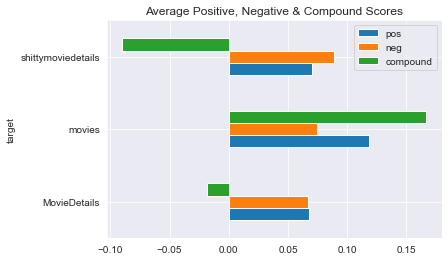

In [59]:
#Plot the average positivity, negativity and compound scores for target
sentiment_df.groupby('target').mean()[['pos', 'neg', 'compound']].plot(kind='barh')
plt.title('Average Positive, Negative & Compound Scores');

In [60]:
#pair-plot relationships btn. top words / sentiment and word length etc.
#Some inspiration from Ben's work


### Vectorize text in prep for analysis

We will need to vectorize our words, for our models to process them. 
We will vectorize self-text, as well as, potentially, title and / or our joint text column to train on.

In [61]:
#initialize CV transformer
cvec = CountVectorizer(stop_words='english', max_features = 500)

### Word analysis

In [62]:
word_counts = cvec.fit_transform(df['selftext'])

In [63]:
type(word_counts)

scipy.sparse.csr.csr_matrix

In [64]:
counts = pd.DataFrame(word_counts.todense(), columns=cvec.get_feature_names())

How many words do we have in the post column?

In [65]:
counts.sum().sum()
#note: identical calc to doing this as `word_counts.sum()`

76941

Let's create a new column called "post length" that calculates the words contained in a post's body.

In [66]:
#get length of posts
df['post_length'] = df['selftext'].map(lambda x: len(x.split()))

In [67]:
#take a peek
df.sort_values(by = 'selftext', ascending = False).head()

,index,title,selftext,subreddit,created_utc,author,is_self,score,num_comments,timestamp,all_text,post_length
20395,7446,I really don t like the live action Mulan,tl dr The new Mulan sucksI m Chinese so I was excited as hell that we were getting a new grittier Mulan that seemed to pay more homage to the original legend and was more respectful to Chinese...,movies,1970-01-01 00:00:01.604190060,Puff the penguin,True,1,14,2020-10-31,I really don t like the live action Mulan. tl dr The new Mulan sucksI m Chinese so I was excited as hell that we were getting a new grittier Mulan that seemed to pay more homage to the original...,430
13068,6176,In the movie The Founder 2016 Ray Kroc says every McDonalds burger must have 3 pickles Well today my McDonalds burgers both only had 2 pickles Is this movie even accurate I am outraged an...,tl dr outraged Michael Keaton must respond,MovieDetails,1970-01-01 00:00:01.604262582,fatal music,True,1,2,2020-11-01,In the movie The Founder 2016 Ray Kroc says every McDonalds burger must have 3 pickles Well today my McDonalds burgers both only had 2 pickles Is this movie even accurate I am outraged an...,7
15673,324,Help find a puppet movie,this was a movie that took place in a steampunk asian setting the characters were glove puppets like thunderbolt fantasy or pili and there was a robot the movie tittle is also the name of the r...,movies,1970-01-01 00:00:01.618700964,hellowhatareyou,True,1,4,2021-04-17,Help find a puppet movie. this was a movie that took place in a steampunk asian setting the characters were glove puppets like thunderbolt fantasy or pili and there was a robot the movie tittle...,111
16572,1644,the flying fish scene in Life of Pi is the best use of 3D i ve seen,this is the scene i saw this movie back in 2012 in 3D and it was so good probably the best movie i ve seen in 3D in rewatching it i m still so impressed by the feel of the flying fish scene ...,movies,1970-01-01 00:00:01.615421072,seethar,True,1,16,2021-03-10,the flying fish scene in Life of Pi is the best use of 3D i ve seen. this is the scene i saw this movie back in 2012 in 3D and it was so good probably the best movie i ve seen in 3D in rewa...,130
16796,2050,District 9 is still one of my fav sci fi,this is a random post but I just rewatched this again on crackle and I love this movie man I m not huge into scifi like some but I like it enough if it s compelling material wether book media s...,movies,1970-01-01 00:00:01.614730206,Consistent Ad 9153,True,1,257,2021-03-02,District 9 is still one of my fav sci fi. this is a random post but I just rewatched this again on crackle and I love this movie man I m not huge into scifi like some but I like it enough if it ...,237


What is the most typical post length?

In [68]:
#check for average post density -- length of posts
len(df['selftext'].mode())

1

Let's visualize post length, by subReddit.

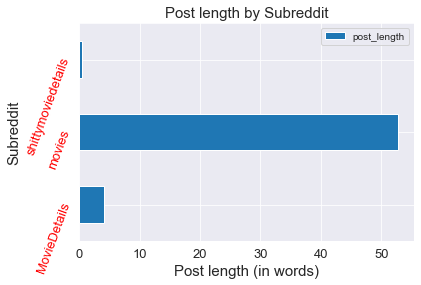

In [69]:
#inspiration from Gwen's NLP lab review

df.groupby('subreddit')[['post_length']].mean().plot(kind='barh');
plt.xticks(size=13);
plt.yticks(size=13, rotation = 70, color = 'red'); #rotation added in order to fit labels
plt.ylabel('Subreddit', size=15)
plt.xlabel('Post length (in words)', size=15);
plt.title('Post length by Subreddit', size=15);
plt.savefig('../images/post_length.png')

It seems that post length varies significantly by the type of subreddit, whoa! Is this a dead giveaway of how our models might perform? (Insert suspenseful music here.)

Suffice it to say, I see promise of a signal there!

In [70]:
#post length vs. scores
#group by post length being above or below the mean, and look at whether the avg. post score changes

What are the most common words?

In [71]:
type(counts)

pandas.core.frame.DataFrame

In [72]:
#word freq analysis - Gwen's lab review code
counts.sum().sort_values(ascending=False).head(30).T

movie        3015
like         1771
just         1718
film         1540
movies       1501
think         979
really        896
time          877
know          773
good          746
ve            728
don           691
people        666
films         618
watch         601
scene         549
great         518
seen          503
story         487
way           481
love          480
watching      433
make          414
did           411
character     401
best          400
remember      397
watched       391
man           381
end           370
dtype: int64

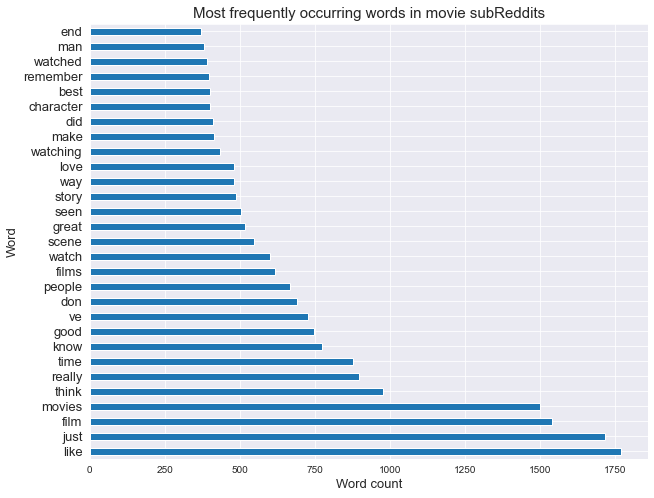

In [73]:
#Gwen's lab review code
plt.figure(figsize=(10,8))
counts.sum().sort_values(ascending=False).head(30)[1:].plot(kind='barh');
plt.title('Most frequently occurring words in movie subReddits', size = 15);
plt.xlabel('Word count', size =13);
plt.yticks(size=13);
plt.ylabel('Word', size=13);
plt.savefig('../images/word_freq.png')

Ok, so words like 'watch', 'scene' and 'films' come up a lot. This is not particularly exciting and would be expected for a movie themed post. Let's look at word pairs.

In [87]:
#look at bi-grams / tri-grams
#consult Gwen's NLP lab review notebook (fb status analysis) for this!
cvec2 = CountVectorizer(stop_words='english', ngram_range=(2,2), max_features = 30)
ngram = cvec2.fit_transform(df['selftext'])
ngrams = pd.DataFrame(ngram.todense(), columns = cvec2.get_feature_names())

In [88]:
type(ngrams)

pandas.core.frame.DataFrame

In [89]:
ngrams.columns

Index(['00 pm', 'boycott tom', 'click rankings', 'don know', 'don think',
       'feel like', 'feels like', 'felt like', 'filler text', 'film like',
       'haven seen', 'high school', 'jerry boycott', 'just watched',
       'main character', 'movie just', 'movie like', 'movies like',
       'processing img', 'really good', 'rotten tomatoes', 'sci fi',
       'seen film', 'star wars', 'text filler', 'tom jerry', 've seen',
       'watch movie', 'watched movie', 'years ago'],
      dtype='object')

These are much more interesting and telling previews -- we can start to piece some context together about what people are talking about! All we are looking at, though, is the start and end of our (not so little) output array. How big is this in terms of features?

In [90]:
ngrams.shape

(21798, 30)

Whoa! 150K features! This will take a minute!

In [91]:
bigrams = [col for col in ngrams.columns if len(col.split()) == 2]

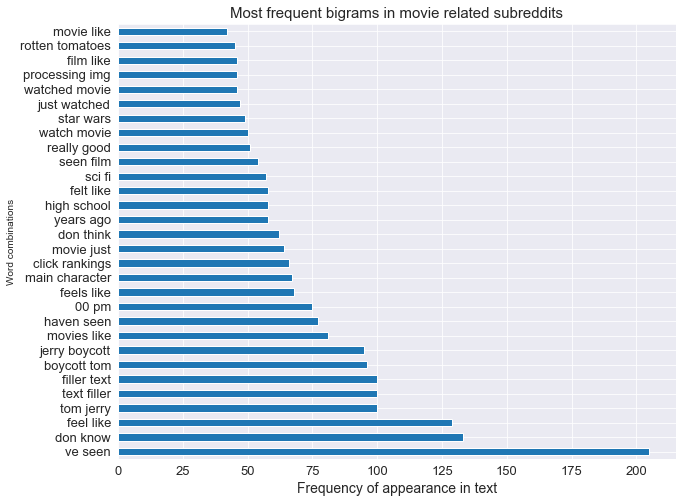

In [92]:
plt.figure(figsize= (10,8))
ngrams[bigrams].sum().sort_values(ascending = False).head(30).plot(kind='barh');
plt.title('Most frequent bigrams in movie related subreddits', size = 15);
plt.yticks(size=13)
plt.xticks(size=13)
plt.xlabel('Frequency of appearance in text', size=14)
plt.ylabel('Word combinations')
plt.savefig('../images/bigrams.png');

These really start to tell some more interesting stories now; we can see things like 'star wars' and 'tom jerry' appearing in here, along with some 'rotten tomatoes' 🍅 and people evidently wanting to boycott Tom and Jerry. Sad cat emoji here.

In [93]:
#stemming / lemmatizing -- if time

In [94]:
#parts of speech -- if time

- - -
## Part IV: Modeling

Several classification models are availed to us. We will try the merits of different ones, potentially including:

* KNN
* Decision Trees
* Random Forest
* Bayes
* Logistic regression (NOTE: this one only makes sense if we find some linearity in earlier text relationship analysis)
* Boosting

We will tune and random-search for best parameters, where appropriate.

### Transform and preprocess

In [127]:
sentiment_df.head(2)

,index,neg,neu,pos,compound,all_text,target
0,0,0.0,1.0,0.0,0.0,In the movie Bullworth 1998 a police officer is seen not shooting black people .,shittymoviedetails
1,1,0.0,1.0,0.0,0.0,The Nightmare Before Christmas 1993 when he arrives at Christmas Town Jack sings what s this There s white things in the air 22 seconds later he sings there are children throwing snowball...,shittymoviedetails


In [128]:
#instantiate cvec
cvec_modeling = CountVectorizer(
    stop_words = 'english', 
    max_features = 5_000,
    ngram_range=(1, 2), #uni + bi-grams
) #tinker w/ max features dep. on how long runs

In [129]:
#new word array w/ cvec transform; set X and y
cvec_df = cvec_modeling.fit_transform(sentiment_df['all_text'])
cvec_df=pd.DataFrame(cvec_df.todense(), columns = cvec_modeling.get_feature_names())
features=pd.concat([cvec_df, sentiment_df],axis=1)
X = features.drop(
    columns = ['target', 'all_text']) #been vectorized
feature_names = X.columns
X = np.array(X)
y = np.array(sentiment_df['target'])

In [130]:
#expecting ~5k features
X.shape

(21798, 5004)

In [131]:
#train-test-split
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, random_state = 42)

### Model 1: Random forest

In [132]:
#instantiate and fit. WARNING: Be sure that scaling isn't req. for a particular model
#also define param grid here (ideally)
forest = RandomForestClassifier() #params?? define...
forest.fit(X_train,y_train)

RandomForestClassifier()

In [133]:
#score
forest.score(X_train, y_train), forest.score(X_test, y_test)

(1.0, 0.9897247706422019)

In [134]:
feature_importances = pd.DataFrame(zip(
    feature_names, forest.feature_importances_), columns = ['feature','importance'])
feature_importances.sort_values(by = 'importance', ascending = False).head(30)

,feature,importance
4999,index,0.445397
5003,compound,0.016396
5001,neu,0.015737
5002,pos,0.015010
5000,neg,0.012361
1604,fact,0.008877
3009,movies,0.006716
3660,reference,0.006490
2966,movie,0.006027
4470,think,0.004957
